In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.merge import add
from keras.models import Model
from keras import Input, layers
from keras.preprocessing.sequence import pad_sequences
from pickle import dump, load
from keras.preprocessing import image
from keras.utils import to_categorical
from time import time
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob

In [3]:
def save_model(model, filename):
    model_json = model.to_json()
    with open(filename + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(filename + ".h5")
    print("Saved model to disk")

In [4]:
def load_descriptions(filename):
    file = open(filename, 'r')
    doc = file.read()
    file.close()
    
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

In [5]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [6]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [7]:
images = '../../datasets/flickr8k/Flicker8k_Dataset/'
train_images_file = '../../datasets/flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_file = '../../datasets/flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
img = glob.glob(images + '*.jpg')

### Get full path to all train images

In [8]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []
for i in img:
    if i[len(images):] in train_images:
        train_img.append(i)

### Get full path all test images

In [9]:
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []
for i in img:
    if i[len(images):] in test_images:
        test_img.append(i)

In [10]:
train_descriptions = load_descriptions('train_captions.txt')
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [11]:
test_descriptions = load_descriptions('test_captions.txt')
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


### encode train images

In [14]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 796.1445319652557


In [15]:
import pickle as p
# Save the bottleneck train features to disk
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    p.dump(encoding_train, encoded_pickle)

In [16]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 137.72195291519165


In [17]:
# Save the bottleneck test features to disk
with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    p.dump(encoding_test, encoded_pickle)

## InceptionV3

In [12]:
model = InceptionV3(weights='imagenet')

In [13]:
model_new = Model(model.input, model.layers[-2].output)

In [18]:
train_features = load(open("./encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [19]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [20]:
# # Consider only words which occur at least 10 times in the corpus
# word_count_threshold = 10
# word_counts = {}
# nsents = 0
# for sent in all_train_captions:
#     nsents += 1
#     for w in sent.split(' '):
#         word_counts[w] = word_counts.get(w, 0) + 1

# vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
# print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

In [21]:
vocab = set()
for sent in all_train_captions:
    for w in sent.split(' '):
        vocab.add(w)
vocab = list(vocab)

In [22]:
len(vocab)

7578

In [23]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [50]:
import pickle as p
# Save the bottleneck train features to disk
with open("./wordtoix.pkl", "wb") as encoded_pickle:
    p.dump(wordtoix, encoded_pickle)

In [52]:
import pickle as p
# Save the bottleneck train features to disk
with open("./ixtoword.pkl", "wb") as encoded_pickle:
    p.dump(ixtoword, encoded_pickle)

In [24]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

7579

In [25]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [27]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [28]:
# Load Glove vectors
glove_dir = './'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [29]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [30]:
embedding_matrix.shape

(7579, 200)

# Model

In [31]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      1515800     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [33]:
model.layers[2]

In [34]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [36]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [37]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    save_model(model, './model_weights/model_' + str(i))
#     model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 565s 282ms/step - loss: 4.6029
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 517s 259ms/step - loss: 3.7717
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 514s 257ms/step - loss: 3.4762
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 508s 254ms/step - loss: 3.2902
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 524s 262ms/step - loss: 3.1484
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 536s 268ms/step - loss: 3.0403
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 590s 295ms/step - loss: 2.9496
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 579s 289ms/step - loss: 2.8798
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 566s 283ms/step - loss: 2.8263
Saved model to disk
Epoch 1/1
2000/2000 [=========================

In [53]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    save_model(model, './model_weights/model_' + str(i+10))
#     model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 437s 218ms/step - loss: 2.7405
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 439s 219ms/step - loss: 2.7073
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 432s 216ms/step - loss: 2.6769
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 39887s 20s/step - loss: 2.6505
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 474s 237ms/step - loss: 2.6281
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 462s 231ms/step - loss: 2.6084
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 490s 245ms/step - loss: 2.5898
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 537s 268ms/step - loss: 2.5767
Saved model to disk
Epoch 1/1
2000/2000 [==============================] - 614s 307ms/step - loss: 2.5617
Saved model to disk
Epoch 1/1
2000/2000 [=========================

In [51]:
wordtoix

{'tracksuit': 1,
 'pug': 2,
 'operate': 3,
 'cow': 4,
 'airplane': 5,
 'daschund': 6,
 'trampoline': 7,
 'plaza': 8,
 'anime': 9,
 'philadelphia': 10,
 'arch': 11,
 'circle': 12,
 'obscure': 13,
 'coldweather': 14,
 'schoolgirls': 15,
 'jungle': 16,
 'board': 17,
 'spinning': 18,
 'canal': 19,
 'inlineskates': 20,
 'grandmother': 21,
 'perched': 22,
 'shape': 23,
 'child': 24,
 'triangular': 25,
 'condominium': 26,
 'steap': 27,
 'strong': 28,
 'movers': 29,
 'ankledeep': 30,
 'dolls': 31,
 'seat': 32,
 'beginning': 33,
 'camp': 34,
 'spikes': 35,
 'press': 36,
 'coaster': 37,
 'uphill': 38,
 'pop': 39,
 'tossing': 40,
 'raises': 41,
 'position': 42,
 'greyish': 43,
 'aids': 44,
 'since': 45,
 'tunnel': 46,
 'wipes': 47,
 'brave': 48,
 'modifications': 49,
 'converge': 50,
 'features': 51,
 'skiny': 52,
 'apparel': 53,
 'retrieved': 54,
 'ramp': 55,
 'cardigan': 56,
 'whack': 57,
 'wheels': 58,
 'numerous': 59,
 'tugowar': 60,
 'artists': 61,
 'broad': 62,
 'mountin': 63,
 'quad': 64,


# Test model

In [39]:
with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [40]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
#         print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
#         print(sequence)
        yhat = model.predict([photo,sequence], verbose=0)
#         print(yhat)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      1515800     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [47]:
wordtoix

{'tracksuit': 1,
 'pug': 2,
 'operate': 3,
 'cow': 4,
 'airplane': 5,
 'daschund': 6,
 'trampoline': 7,
 'plaza': 8,
 'anime': 9,
 'philadelphia': 10,
 'arch': 11,
 'circle': 12,
 'obscure': 13,
 'coldweather': 14,
 'schoolgirls': 15,
 'jungle': 16,
 'board': 17,
 'spinning': 18,
 'canal': 19,
 'inlineskates': 20,
 'grandmother': 21,
 'perched': 22,
 'shape': 23,
 'child': 24,
 'triangular': 25,
 'condominium': 26,
 'steap': 27,
 'strong': 28,
 'movers': 29,
 'ankledeep': 30,
 'dolls': 31,
 'seat': 32,
 'beginning': 33,
 'camp': 34,
 'spikes': 35,
 'press': 36,
 'coaster': 37,
 'uphill': 38,
 'pop': 39,
 'tossing': 40,
 'raises': 41,
 'position': 42,
 'greyish': 43,
 'aids': 44,
 'since': 45,
 'tunnel': 46,
 'wipes': 47,
 'brave': 48,
 'modifications': 49,
 'converge': 50,
 'features': 51,
 'skiny': 52,
 'apparel': 53,
 'retrieved': 54,
 'ramp': 55,
 'cardigan': 56,
 'whack': 57,
 'wheels': 58,
 'numerous': 59,
 'tugowar': 60,
 'artists': 61,
 'broad': 62,
 'mountin': 63,
 'quad': 64,


In [41]:
encoding_test

{'2869491449_1041485a6b.jpg': array([0.23307075, 0.11945589, 0.06828227, ..., 0.1356286 , 0.28686804,
        0.46626177], dtype=float32),
 '2924259848_effb4dcb82.jpg': array([0.08335664, 0.4748026 , 0.        , ..., 0.41408813, 0.3460163 ,
        0.32229453], dtype=float32),
 '2300168895_a9b83e16fc.jpg': array([0.47549912, 0.16413186, 0.10513148, ..., 0.2283283 , 0.6016424 ,
        0.33787268], dtype=float32),
 '3530843182_35af2c821c.jpg': array([0.29510352, 0.66720843, 0.7723508 , ..., 0.88509566, 0.61207336,
        0.14146899], dtype=float32),
 '3439382048_d2e23b2b4c.jpg': array([0.07332887, 0.246973  , 0.4417062 , ..., 0.2256542 , 0.07035305,
        0.7182994 ], dtype=float32),
 '3592992234_6d3fe58a70.jpg': array([0.16071428, 0.03060498, 0.22917935, ..., 0.19445169, 0.2503612 ,
        0.20583896], dtype=float32),
 '3568197730_a071d7595b.jpg': array([0.1268359 , 0.33334106, 0.08806673, ..., 0.22251524, 0.29994935,
        0.20202377], dtype=float32),
 '2843695880_eeea6c67db.jpg

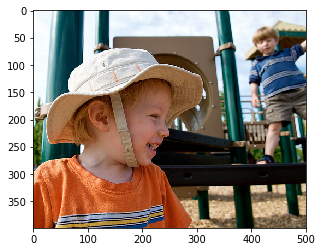

Greedy: two girls are sitting on the grass


In [43]:
#z+=1
z=18
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [ ]:
#z+=1
z=16
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [ ]:
ixtoword[5180]

In [ ]:
test_descriptions['2869491449_1041485a6b']

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)